In [1]:
from lib.environments import AdvectionEnvironment
from lib.models import AdvectionIRCNN
from lib.models.wrappers import MarlModel
from tianshou.utils.net.common import ActorCritic
from lib.policy.ppo import MarlPPOPolicy
from lib.distributions import ElementwiseNormal

import torch
import math
import numpy as np
from tqdm import tqdm
from copy import deepcopy
import pickle
import os

# Plotting settings
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
FONT_SIZE = 16
FIG_SIZE = (4, 3.5)
plt.rcParams['figure.figsize'] = FIG_SIZE
# Set global font size
plt.rcParams['font.size'] = FONT_SIZE
plt.rcParams['axes.labelsize'] = FONT_SIZE
plt.rcParams['xtick.labelsize'] = FONT_SIZE
plt.rcParams['ytick.labelsize'] = FONT_SIZE
plt.rcParams['legend.fontsize'] = 12

# This serves to assure Type 1 fonts
plt.rcParams['text.usetex'] = False
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['ps.useafm'] = True

In [2]:
def plot_n(ims, titles=None):   
    fig, axes = plt.subplots(1, len(ims), figsize=(7, 5))
    for i, (ax, im) in enumerate(zip(axes, ims)):
        ax.imshow(im, vmin=-0, vmax=1, cmap='gray', interpolation="none")
        ax.axis("off")
        if titles:
            ax.set_title(titles[i])
    plt.show()
        
method_color = {
    "CGS": "red",
    "ACGS": "orange",
    "FGS": "green",
    "CNN-MARL": "blue"
}

In [18]:
class Collector:
    def __init__(self, names):
        self.values = {name: [] for name in names}

    def add(self, name, value):
        self.values[name].append(value)

    def post_collection_processing(self):
        for key, value in self.values.items():
            self.values[key] = np.array(self.values[key])

    def __call__(self, name):
        return self.values[name]

    def __repr__(self):
        self.post_collection_processing()
        description = "Collector( \n"
        for key, value in self.values.items():
            description += f"{key}: {value.shape}, \n"
        description += ")"
        return description

    def load_collection(self, col):
        for key, value in col.values.items():
            self.add(key, value)

def plot_collection(ks, col, label, color, log=False):
    plt.plot(ks, col.mean(axis=0), label=label, color=color)
    plt.fill_between(ks,
                     col.mean(axis=0) - col.std(axis=0),
                     col.mean(axis=0) + col.std(axis=0),
                     color=color, alpha=0.1)
    if log:
        plt.yscale('log')

def plot_collection_individuals(ks, col, label, color, log=False, mode="mean", alpha=.1):
    if mode == "median":
        plt.plot(ks, np.median(col, axis=0), label=label, color=color)
    elif mode == "mean":
        plt.plot(ks, np.mean(col, axis=0), label=label, color=color)
        
    for run in col:
        plt.plot(ks, run, color=color, alpha=alpha)
    if log:
        plt.yscale('log')

def save_col(_col, path):
    print(f"Saved Collection to {_path}")
    with open(path, 'wb') as f:
        pickle.dump(_col, f)

def load_col(path):
    print(f"Loaded Collection from {path}")
    with open(path, 'rb') as f:
        loaded_data = pickle.load(f)
        return loaded_data

In [4]:
DEVICE = "cuda:0"
backbone = AdvectionIRCNN()
actor = MarlModel(backbone=backbone, _is="actor").to(DEVICE)
critic = MarlModel(backbone=backbone, _is="critic").to(DEVICE)
actor_critic = ActorCritic(actor, critic)

In [5]:
EPOCH = 1499  # Load EPOCH=1499 for best model
POLICY_READ_PATH = f'./weights/policy_launch_platform/mnist_train_ppo_IRCNN_eplen:4_seed:0_subsample:4_discount:0.95_growing_ep_len_maxed/policy_ep{EPOCH}.pt'

In [6]:
dist = ElementwiseNormal
ElementwiseNormal.marl = True
policy = MarlPPOPolicy(actor=actor_critic.actor,
             critic=actor_critic.critic,
              dist_fn=dist,
              optim=None,
             ent_coef=0.05)
policy.load_state_dict(torch.load(POLICY_READ_PATH, map_location=torch.device(DEVICE)))
print("Built model")

Built model


In [7]:
DATA_SET_NAME = "mnist"
VEL_FIELD_TYPE = "train"

FIG_PATH = f'results_dump/figures/advection/'
SAVE_PATH = f'results_dump/data/advection/'
LOAD_PATH = f'results/data/advection/'

os.makedirs(os.path.dirname(FIG_PATH), exist_ok=True)
os.makedirs(os.path.dirname(SAVE_PATH), exist_ok=True)

env = AdvectionEnvironment(
    ep_len=10,
    train=False,
    img_size=64,
    dataset_name=DATA_SET_NAME,
    velocity_field_type=VEL_FIELD_TYPE
)

# Simulation

In [8]:
def get_action(actor, deterministic, obs):
    if deterministic:
        act_mean = actor.get_action_mean(obs).detach().squeeze().cpu().numpy()
    else:
        act_mean = actor.sample_action(obs).detach().squeeze().cpu().numpy()
    return act_mean


def run_simulation(num_steps=100, do_plot=False, deterministic=True):
    _obs, _ = env.reset()
    no_rl = deepcopy(env.state)
    no_rl_gt = deepcopy(env.state)
    for i in range(num_steps):

        act_mean = get_action(actor, deterministic, _obs)

        _obs, _, _, _, _ = env.step(np.expand_dims(act_mean, axis=0))
    
        no_rl = env.upwind_scheme_2d_step(no_rl, env.dt, env.dx, env.dy, env.c_x, env.c_y)
        no_rl_gt = env.rk4_step(no_rl_gt, env.dt, env.dx, env.dy, env.c_x, env.c_y, space_disc="second_order_upwind")

        # Plot state every 50 steps
        if i % 50 == 0 and do_plot:
            print(f"Num CGS steps: {i}")
            base = "$\widetilde{\psi}^{" + str(i) + "}"
            plot_n([no_rl, env.state, env.gt_state[::env.subsample, ::env.subsample]],
                       titles=["CGS", "CNN-MARL", "FGS"] if i == 0 else None)

    gt = env.gt_state[::env.subsample, ::env.subsample]
    if do_plot:
        plot_n([no_rl, env.state, env.gt_state[::env.subsample, ::env.subsample]])
    return gt, env.state, no_rl, no_rl_gt, act_mean

<>:25: DeprecationWarning: invalid escape sequence '\w'


## Qualitative Results

Num CGS steps: 0


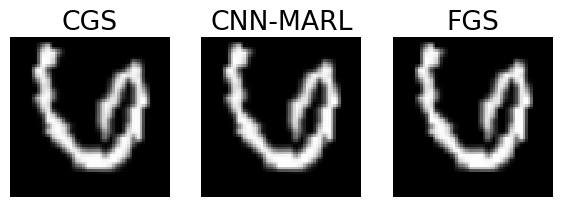

Num CGS steps: 50


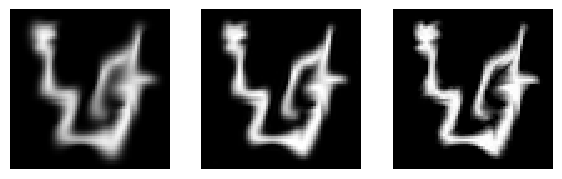

Num CGS steps: 100


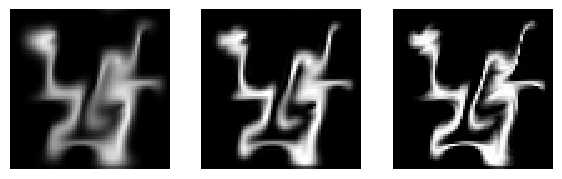

Num CGS steps: 150


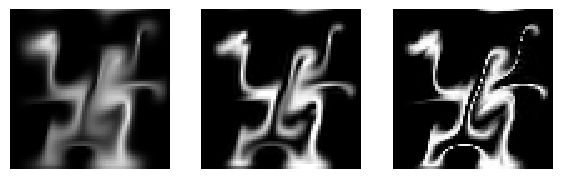

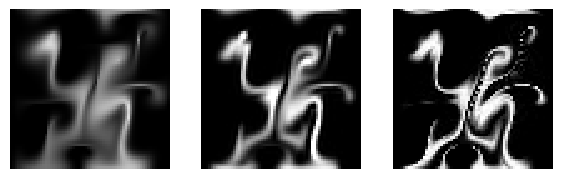

In [11]:
_ = run_simulation(200, do_plot=True)

## Multiple Simulations for Quantitative Results

In [16]:
NUM_SIMS = 2
NUM_STEPS = 50

col = Collector(["s_no_rl",  "s_rl", "s_no_rl_gt", "s_gt", 
                 "eng_gt", "eng_rl", "eng_no_rl", "eng_no_rl_gt", 
                 "act" ])

for sim in tqdm(range(NUM_SIMS)):
    # run simulation and collect end states
    gt, rl, no_rl, no_rl_gt, act_mean = run_simulation(NUM_STEPS)
    col.add("s_gt", gt)
    col.add("s_rl", rl)
    col.add("s_no_rl", no_rl)    
    col.add("s_no_rl_gt", no_rl_gt)
    col.add("act", act_mean)

    # Compute energy spectra and collect them
    ks, gt_eng = env.compute_energy_spectrum(gt)
    _, rl_eng = env.compute_energy_spectrum(rl)
    _, no_rl_eng = env.compute_energy_spectrum(no_rl)
    _, no_rl_gt_eng = env.compute_energy_spectrum(no_rl_gt)

    col.add("eng_gt", gt_eng)
    col.add("eng_rl", rl_eng)
    col.add("eng_no_rl", no_rl_eng)
    col.add("eng_no_rl_gt", no_rl_gt_eng)


# convert to np arrays
col.post_collection_processing()


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:11<00:00,  5.81s/it]


In [17]:
# Saving
_path = SAVE_PATH + f"{NUM_STEPS}steps_{DATA_SET_NAME}_{VEL_FIELD_TYPE}_end_results"
save_col(col, path=_path)

Saved Collection to results_dump/data/advection/50steps_mnist_train_end_results


## Analysis of Quantitative Results

In [84]:
DATA_SET_NAME = "mnist"  # mnist, fashion
VEL_FIELD_TYPE = "train" # train, vortex

NUM_STEPS = 50
_path = LOAD_PATH + f"MAE@step50/{NUM_STEPS}steps_{DATA_SET_NAME}_{VEL_FIELD_TYPE}_end_results.pkl"
col = load_col(path=_path)

Loaded Collection from results/data/advection/MAE@step50/50steps_mnist_train_end_results.pkl


In [85]:
NUM_SIMS = col("s_gt").shape[0]
NUM_SIMS, NUM_STEPS 

(100, 50)

In [86]:
# Computing errors
no_rl_error_col = np.abs(col("s_no_rl")-col("s_gt"))
no_rl_gt_error_col = np.abs(col("s_no_rl_gt")-col("s_gt"))
rl_error_col = np.abs(col("s_rl")-col("s_gt"))

Errors are scaled by $10^2$
CGS: 3.1347 +- 0.8039 | (-0.00%) w.r.t. CGS
ACGS: 1.9045 +- 0.5053 | (-39.24%) w.r.t. CGS
CNN-MARL: 1.4570 +- 0.3337 | (-53.52%) w.r.t. CGS


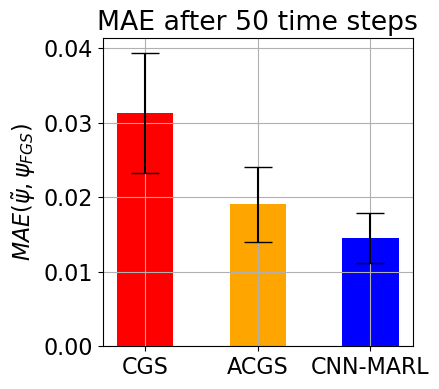

In [87]:
plt.figure(figsize=(4, 4)) 
categories = ["CGS",  "ACGS", "CNN-MARL"]
values = [no_rl_error_col.mean(), no_rl_gt_error_col.mean(), rl_error_col.mean()]
yerr = [no_rl_error_col.mean(axis=(1, 2)).std(), no_rl_gt_error_col.mean(axis=(1, 2)).std(), rl_error_col.mean(axis=(1, 2)).std()]
colors = [method_color[cat] for cat in categories]
plt.bar(categories, values, color=colors, yerr=yerr, width=0.5, capsize=10, log=False)
plt.title(f"MAE after {NUM_STEPS} time steps")
plt.ylabel(r"$MAE(\tilde \psi, \psi_{FGS})$")
plt.grid(True)

no_rl_error = no_rl_error_col.mean()
print("Errors are scaled by $10^2$")
for cat, value, std in zip(categories, values, yerr):
    print(f"{cat}: {100*value:.4f} +- {100*std:.4f} | (-{(no_rl_error - value)/no_rl_error:.2%}) w.r.t. CGS")

# Evolution of Metrics

In [69]:
def run_sim_and_collect_time_evolving_metrics(num_steps=100, do_plot=False, deterministic=True):

    _col = Collector(["err_rl", "err_no_rl", "err_no_rl_gt",
                      "eng_err_rl", "eng_err_no_rl", "eng_err_no_rl_gt",
                      "acts"])
    
    _obs, _ = env.reset()
    no_rl = deepcopy(env.state)
    no_rl_gt = deepcopy(env.state)
    
    for i in range(num_steps):
        if deterministic:
            act_mean = actor.get_action_mean(_obs).detach().squeeze().cpu().numpy()
        else:
            act_mean = actor.sample_action(_obs).detach().squeeze().cpu().numpy()        
        _col.add("acts", act_mean)
        
        _obs, _, _, _, _ = env.step(np.expand_dims(act_mean, axis=0))
        no_rl = env.upwind_scheme_2d_step(no_rl, env.dt, env.dx, env.dy, env.c_x, env.c_y)
        no_rl_gt = env.rk4_step(no_rl_gt, env.dt, env.dx, env.dy, env.c_x, env.c_y, space_disc="second_order_upwind")

        # MAE domain error
        rl_error = np.mean(np.abs(env.gt_state[::env.subsample, ::env.subsample] - env.state))
        no_rl_error = np.mean(np.abs(env.gt_state[::env.subsample, ::env.subsample] - no_rl))
        no_rl_gt_error = np.mean(np.abs(env.gt_state[::env.subsample, ::env.subsample] - no_rl_gt))
        _col.add("err_rl", rl_error)
        _col.add("err_no_rl", no_rl_error)
        _col.add("err_no_rl_gt", no_rl_gt_error)


        # energy spectrum error
        ks, gt_eng = env.compute_energy_spectrum(env.gt_state[::env.subsample, ::env.subsample])
        _, rl_eng = env.compute_energy_spectrum(env.state)
        _, no_rl_eng = env.compute_energy_spectrum(no_rl)
        _, no_rl_gt_eng = env.compute_energy_spectrum(no_rl_gt)

        _col.add("eng_err_rl", np.sum(env.energ_spec_error(rl_eng, gt_eng)))
        _col.add("eng_err_no_rl", np.sum(env.energ_spec_error(no_rl_eng, gt_eng)))
        _col.add("eng_err_no_rl_gt", np.sum(env.energ_spec_error(no_rl_gt_eng, gt_eng)))

        
        if i % 50 == 0 and do_plot:
            plot_n([no_rl, env.state, env.gt_state[::env.subsample, ::env.subsample]])
    
    _col.post_collection_processing()
    return _col


In [161]:
NUM_STEPS = 400
NUM_SIMS = 100

col_2 = Collector(["err_rl", "err_no_rl", "err_no_rl_gt",
                  "eng_err_rl", "eng_err_no_rl", "eng_err_no_rl_gt",
                  "acts"])

for sim in tqdm(range(NUM_SIMS)):
    col = run_sim_and_collect_time_evolving_metrics(num_steps=NUM_STEPS)
    col_2.load_collection(col)

col_2.post_collection_processing()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:15:45<00:00, 45.45s/it]


In [162]:
_path = SAVE_PATH + f"{NUM_STEPS}steps_{NUM_SIMS}sims_{DATA_SET_NAME}_{VEL_FIELD_TYPE}_evolution.pkl"
save_col(col_2, path=_path)

# Analysis

In [88]:
NUM_STEPS = 400
NUM_SIMS = 100

_path = LOAD_PATH + f"metric_evolution/{NUM_STEPS}steps_{NUM_SIMS}sims_mnist_train_evolution.pkl"
col_2 = load_col(path=_path)

Loaded Collection from results/data/advection/metric_evolution/400steps_100sims_mnist_train_evolution.pkl


In [89]:
SIM_LEN = col_2("err_rl").shape[1]


Threshold: 0.01
CNN-MARL: 31.7800 +- 18.4795 | (+163.30%)
ACGS: 22.0300 +- 11.5130 | (+82.52%)
CGS: 12.0700 +- 5.6855 | (+0.00%)


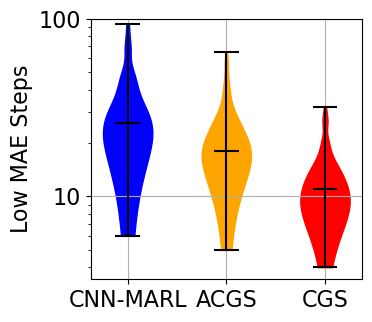

In [90]:
threshold = 0.01
categories = ["err_rl", "err_no_rl_gt", "err_no_rl"]

# Collect raw data points for each category
data_points = [np.argmax(col_2(cat) > threshold, axis=1) for cat in categories]

plt.figure(figsize=FIG_SIZE) 

# Set labels and titles
labels = ["CNN-MARL", "ACGS", "CGS"]
colors = [method_color[cat] for cat in labels]

# Create the violin plot
violin_parts = plt.violinplot(data_points, showmeans=False, showmedians=True)

# Apply colors to each violin
for i, body in enumerate(violin_parts['bodies']):
    body.set_color(colors[i])
    body.set_alpha(1)

violin_parts['cbars'].set_edgecolor('black') 
violin_parts['cmaxes'].set_edgecolor('black') 
violin_parts['cmins'].set_edgecolor('black') 
violin_parts['cmedians'].set_edgecolor('black') 

plt.yscale("log")
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.xticks(ticks=[1, 2, 3], labels=labels)  # Adjust ticks to match the number of categories
plt.ylim(top=100)
plt.ylabel("Low MAE Steps")
plt.grid(True)

values = [np.mean(low_mae_simlen) for low_mae_simlen in data_points]
yerr = [np.std(low_mae_simlen) for low_mae_simlen in data_points]
cgs_value = values[-1]
print(f"\nThreshold: {threshold}")
for cat, value, std in zip(labels, values, yerr):
    print(f"{cat}: {value:.4f} +- {std:.4f} | (+{(value-cgs_value)/cgs_value:.2%})")
plt.tight_layout()
plt.savefig(FIG_PATH + f'low_MAE_{threshold}_violin{SIM_LEN}steps_{NUM_SIMS}sims.pdf')

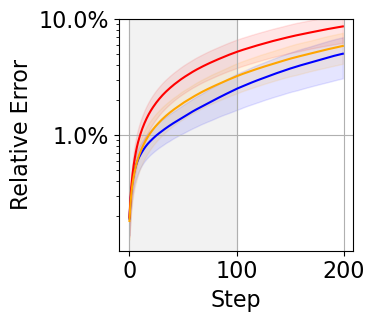

In [93]:
max_n = 200  # num_steps
plt.figure(figsize=FIG_SIZE) 
plot_collection(range(max_n), 100*col_2("err_rl")[:, :max_n], label="CNN-MARL", color=method_color["CNN-MARL"], log=False)
plot_collection(range(max_n), 100*col_2("err_no_rl")[:, :max_n], label="CGS", color=method_color["CGS"])
plot_collection(range(max_n), 100*col_2("err_no_rl_gt")[:, :max_n], label="ACGS", color=method_color["ACGS"])

N_TRAIN_MAX = 100

#plt.title(r"Evolution of Error $MAE(\tilde \psi, \psi_{FGS})$")
plt.xlabel("Step")
plt.ylabel(r"Relative Error")
plt.yscale("log")
plt.ylim(top=10)
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.PercentFormatter())
plt.axvspan(0, N_TRAIN_MAX, color='grey', alpha=0.1, label="Training regime")
#plt.legend(loc='lower right', edgecolor='black')
plt.grid(True)
plt.tight_layout()
plt.savefig(FIG_PATH + f'relative_MAE_evol_{max_n}steps_{NUM_SIMS}sims.pdf')  # Saving as PDF

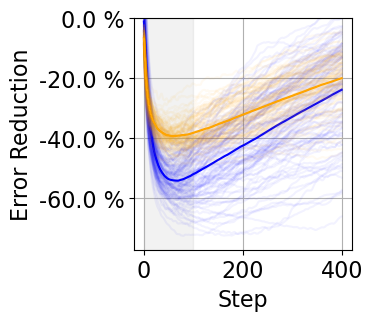

In [94]:
max_n = SIM_LEN
plt.figure(figsize=FIG_SIZE) 
plot_collection_individuals(range(max_n), -100*(col_2("err_no_rl")[:, :max_n]-col_2("err_rl")[:, :max_n]) / col_2("err_no_rl")[:, :max_n], label="CNN-MARL", color=method_color["CNN-MARL"], log=False, alpha=.05)
plot_collection_individuals(range(max_n), -100*(col_2("err_no_rl")[:, :max_n]-col_2("err_no_rl_gt")[:, :max_n]) / col_2("err_no_rl")[:, :max_n], label="ACGS", color=method_color["ACGS"], log=False, alpha=.05)
plt.axvspan(0, N_TRAIN_MAX, color='grey', alpha=0.1, label="training regime")

ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{x} %"))
plt.grid(True)
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.4), edgecolor='black')
plt.tight_layout()
plt.ylabel("Error Reduction")
plt.xlabel("Step")
plt.ylim(top=0)
plt.tight_layout()
plt.savefig(FIG_PATH + f'outperformance_evol_{max_n}steps_{NUM_SIMS}sims.pdf')  # Saving as PDF

# GIF Generation

In [66]:
def run_sim_and_collect_states(num_steps=100, do_plot=False, deterministic=True):

    _col = Collector(["no_rl", "rl", "gt"])
    
    _obs, _ = env.reset()
    no_rl = deepcopy(env.state)
    no_rl_gt = deepcopy(env.state)
    
    for i in range(num_steps):
        _col.add("no_rl", no_rl)
        _col.add("rl", env.state)
        _col.add("gt", no_rl_gt)
        if deterministic:
            act_mean = actor.get_action_mean(_obs).detach().squeeze().cpu().numpy()
        else:
            act_mean = actor.sample_action(_obs).detach().squeeze().cpu().numpy()        
        
        _obs, _, _, _, _ = env.step(np.expand_dims(act_mean, axis=0))
        no_rl = env.upwind_scheme_2d_step(no_rl, env.dt, env.dx, env.dy, env.c_x, env.c_y)
        no_rl_gt = env.rk4_step(no_rl_gt, env.dt, env.dx, env.dy, env.c_x, env.c_y, space_disc="second_order_upwind")
        
        if i % 50 == 0 and do_plot:
            plot_n([no_rl, env.state, env.gt_state[::env.subsample, ::env.subsample]])
    
    _col.post_collection_processing()
    return _col


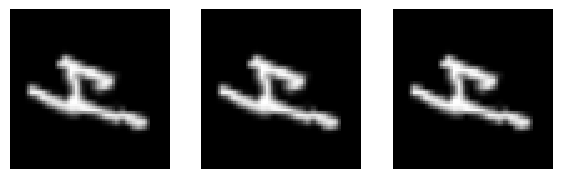

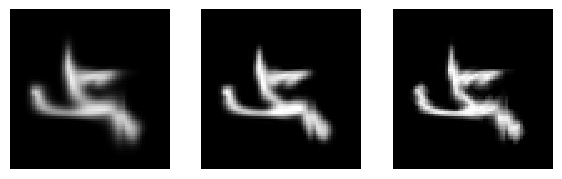

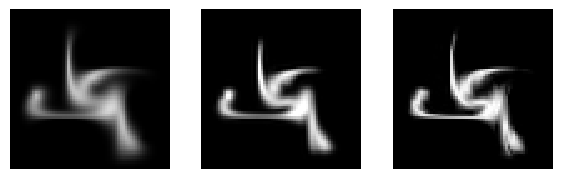

In [67]:
col = run_sim_and_collect_states(num_steps=150, do_plot=True)

In [68]:
import imageio

def save_sim_to_gif(_col):
    gif_path = "gifs/"
    os.makedirs(os.path.dirname(gif_path), exist_ok=True)

    for sim in _col.values.keys():
        # convert from (0, 1) float to (0, 255) uint8
        clipped_sim_frames = np.clip(col(sim) * 255, 0, 255)
        clipped_sim_frames = clipped_sim_frames.astype(np.uint8)
        imageio.mimsave(gif_path + f"{sim}.gif", clipped_sim_frames , format='GIF', fps=20)

In [69]:
save_sim_to_gif(col)

# Speed Tests

In [71]:
from time import time

NUM_SAMPLES = 100

time_col = Collector(["CGS", "CNN-MARL", "ACGS", "FGS"])

for _ in tqdm(range(NUM_SAMPLES)):
    obs, _ = env.reset()
    no_rl_gt = env.state

    # FGS
    begin = time()
    for _ in range(env.subsample):
        env.gt_state = env.rk4_step(env.gt_state, env.dns_dt, env.dns_dx, env.dns_dy,
                                               env.c_x_dns, env.c_y_dns)
    fgs_time = time() - begin
    time_col.add("FGS", fgs_time)

    # CGS
    begin = time()
    env.upwind_scheme_2d_step(env.state, env.dt, env.dx, env.dy, env.c_x, env.c_y)
    cgs_time = time() - begin
    time_col.add("CGS", cgs_time)

    # ACGS
    begin = time()
    env.rk4_step(no_rl_gt, env.dt, env.dx, env.dy, env.c_x, env.c_y, space_disc="second_order_upwind")
    acgs_time = time() - begin
    time_col.add("ACGS", acgs_time)
    
    # CNN-MARL
    begin = time()
    action = actor.get_action_mean(obs).detach().squeeze().cpu().numpy().clip(-1, 1)
    env.rl_adjusted_state = np.clip(env.state - action, env.observation_space.low, env.observation_space.high)
    env.upwind_scheme_2d_step(env.rl_adjusted_state, env.dt, env.dx, env.dy, env.c_x, env.c_y)
    cnn_marl_time = time() - begin
    time_col.add("CNN-MARL", cnn_marl_time)

time_col.post_collection_processing()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.64it/s]


FGS: 117.30 +- 2.02 ms
CNN-MARL: 2.71 +- 0.07 ms
ACGS: 1.26 +- 0.03 ms
CGS: 0.41 +- 0.02 ms

 CGS step time improvement of -99.65% w.r.t. FGS
ACGS step time improvement of -98.93% w.r.t. FGS
CNN-MARL step time improvement of -97.69% w.r.t. FGS


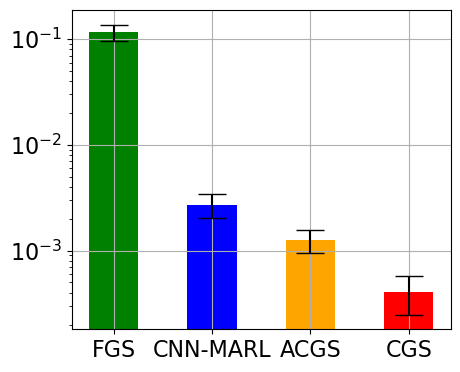

In [72]:
plt.figure(figsize=(5, 4)) 

categories = ["FGS", "CNN-MARL", "ACGS", "CGS"]
values = [time_col(cat).mean() for cat in categories]
yerr = [time_col(cat).std() for cat in categories]
colors = [method_color[cat] for cat in categories]
plt.bar(categories, values, color=colors, yerr=yerr, width=0.5, capsize=10, log=False)
plt.grid(True)
plt.tight_layout()
plt.yscale("log")

for cat, value, std in zip(categories, values, yerr):
    print(f"{cat}: {1000 * value:.2f} +- {100 * std:.2f} ms")

cgs_time = time_col("CGS").mean()
acgs_time = time_col("ACGS").mean()
fgs_time = time_col("FGS").mean()
cnn_marl_time = time_col("CNN-MARL").mean()

print(f"\n CGS step time improvement of -{(fgs_time-cgs_time) / fgs_time :.2%} w.r.t. FGS")
print(f"ACGS step time improvement of -{(fgs_time-acgs_time) / fgs_time :.2%} w.r.t. FGS")
print(f"CNN-MARL step time improvement of -{(fgs_time-cnn_marl_time) / fgs_time :.2%} w.r.t. FGS")